In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as web
from sklearn.linear_model import LinearRegression
import datetime
import pandas_market_calendars as mcal
import matplotlib.pyplot as plt

def add_trading_days(from_date, ndays):
    nyse = mcal.get_calendar('NYSE')
    trading_days = nyse.valid_days(start_date='2000-01-01', end_date="2020-01-01")
    trading_days_to_add = abs(ndays)
    current_date = datetime.datetime.strptime(from_date, '%Y-%m-%d')
    sign = ndays/abs(ndays)
    delta = datetime.timedelta(days=1)
    while trading_days_to_add > 0:
        current_date = (current_date+delta*sign)
        if not current_date in trading_days:
            continue
        trading_days_to_add -= 1
    return current_date.strftime('%Y-%m-%d')

# Get spread between pairs

In [2]:
def getSpread(pairs,end_date,window=60): 
#standing at end_date and calculate spreads in past 60 days  
#     pairs should be in format [[p1,p2],[p1,p2]]
#     return spread, index:date,value:spread
    
    start_date = add_trading_days(end_date,-window)
    spread={}
    beta=[]
    #download data, compute return
    for i,pair in enumerate(pairs):
        stock_data=web.get_data_yahoo(pair, start=start_date, end=end_date)['Adj Close']
        ret = stock_data.pct_change() * 100.0
        ret=ret[1:]
        days=ret.shape[0]
        X=ret[pair[0]].values.reshape((days,1))
        y=ret[pair[1]].values.reshape((days,1))
        lr=LinearRegression().fit(X,y)
        res=(y-lr.predict(X)).reshape(days)
        spread['pair'+str(i+1)]=np.cumsum(res)-np.sum(res)
        beta.append(lr.coef_[0])
    spread=pd.DataFrame(spread,index=stock_data.index[1:])
    return spread,beta

# OU process for calculating today's s-score 

In [3]:
def OU_regression(X): #length of X=60 by default
    x = X[:-1].reshape(-1,1)
    y = X[1:].reshape(-1,1)
    reg = LinearRegression().fit(x,y)
    a = float(reg.intercept_)
    b = float(reg.coef_)
    m = a/(1-b)
    sig_eq = np.std(y-a-b*x)/np.sqrt(1-b**2)
    s = (X[-1]-m)/sig_eq
    return s

# Generate trading signals

In [4]:
#1:buy,-1:sell,0:none——wrt to P
def trade_pos(pairs,window,btwindow,end_date): 
    #window: window phase for calculating spread
    #btwindow: backtest window phase
    
    sbo = sso = 1.25
    sbc = 0.75
    ssc = 0.5
    
    #construct backtest window
    start_date = add_trading_days(end_date,-btwindow)
    price = web.get_data_yahoo(pairs[0], start=start_date, end=end_date)["Adj Close"] #used to determine # of trading days
    dates = price.index.values
    dates = [str(dates[i])[:10] for i in range(len(dates))]
    
    pos = np.zeros((len(price),len(pairs)))
    betas = np.zeros((len(price),len(pairs)))

    for i in range(len(price)): #iterate in the backtest window
        date = dates[i]
        spread,beta = getSpread(pairs,end_date=date,window=window)
        for j in range(len(pairs)):
            betas[i,j]=float(beta[j])
            s = OU_regression(np.array(spread.iloc[:,j])) #calculate today's s-score
            if (i==0 or pos[i-1,j]==0) and s<-sbo:
                pos[i,j] = 1
            elif (i==0 or pos[i-1,j]==0) and s>sso:
                pos[i,j] = -1
            elif i==0:
                continue
            elif (pos[i-1,j]==1 and s>-ssc) or (pos[i-1,j]==-1 and s<sbc):
                pos[i,j] = 0
            else:
                pos[i,j] = pos[i-1,j]
    return pos,betas


# Backtesting

In [5]:
def backtest(initial_capital,pairs,btwindow=251,window=60,end_date='2019-01-01'):
    #determine the backtest window startdate
    start_date = add_trading_days(end_date,-btwindow)
    #generate trading signals in the backtest window
    position, betas =trade_pos(pairs,window,btwindow,end_date)
    
    value=[]
    for j, pair in enumerate(pairs):
        price= web.get_data_yahoo(pair, start=start_date, end=end_date)["Adj Close"]        
        pos = position[:,j]
        beta = betas[:,j]
        v = np.ones(len(pos))*initial_capital
        shares = np.zeros(2)
        for i in range(len(pos)):
            if i==0:
                if pos[i]==0:
                    continue
                elif pos[i]==1:
                    shares[1]= v[i]/price.iloc[i,1]
                    shares[0]= -beta[i]*v[i]/price.iloc[i,0]
                elif pos[i]==-1:
                    shares[1]= -v[i]/beta[i]/price.iloc[i,1]
                    shares[0]= v[i]/price.iloc[i,0]
            elif pos[i]==0 and pos[i-1]==0:
                v[i]=v[i-1]
            elif pos[i]==1 and pos[i-1]==0:
                v[i]=v[i-1]
                shares[1]= v[i]/price.iloc[i,1]
                shares[0]= -beta[i]*v[i]/price.iloc[i,0]
            elif pos[i]==-1 and pos[i-1]==0:
                v[i]=v[i-1]
                shares[1]= -v[i]/beta[i]/price.iloc[i,1]
                shares[0]= v[i]/price.iloc[i,0]
            else:
                v[i]=v[i-1]+shares[0]*(price.iloc[i,0]-price.iloc[i-1,0])+shares[1]*(price.iloc[i,1]-price.iloc[i-1,1])
        value.append(v)
    dates = price.index.values
    return value,position,dates


# Assess strategy performances

In [6]:
def indicator(value):
    port = pd.DataFrame({"value":value})
    port["daily return"] = port["value"].pct_change(1)
    a_return= ((value[-1]-value[0])/value[0])**(252/len(value))
    a_vol = port["daily return"][1:].std()*np.sqrt(252)
    rf = 2.53*0.01 #10 year treasury rate
    a_Sharpe_Ratio = (a_return-rf)/a_vol
    return a_return,a_Sharpe_Ratio  

# Two test examples

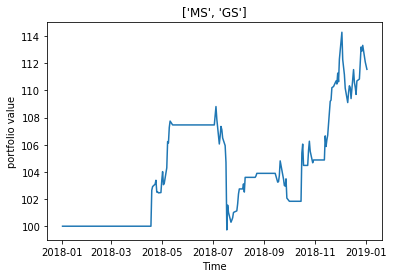

['MS', 'GS'] :
Annualized return: 0.11549700324094615
Annualized Sharpe Ratio: 0.8545174315228833


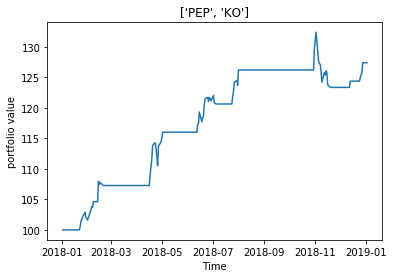

['PEP', 'KO'] :
Annualized return: 0.2737006417206052
Annualized Sharpe Ratio: 2.627704824114986


In [8]:
pairs = [["MS","GS"],["PEP","KO"]]
value,position,dates = backtest(100,pairs,btwindow=251,window=60,end_date='2019-01-01')

for i in range(len(pairs)):
    plt.plot(dates,value[i])
    plt.title(pairs[i])
    plt.xlabel("Time")
    plt.ylabel("portfolio value")
    plt.show()
    a_return,a_Sharpe_Ratio  = indicator(value[i])
    print(pairs[i],":")
    print("Annualized return:",a_return)
    print("Annualized Sharpe Ratio:",a_Sharpe_Ratio)